<a href="https://colab.research.google.com/github/Cicero-art/Projeto_Demissao_Funcionario/blob/master/regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Attrition Analysis Using Logistic Regression

## 1. Introduction

In this project, we aim to predict employee attrition using a logistic regression model. We utilize a dataset that includes various features about employee performance, job satisfaction, and demographics. The goal is to understand the likelihood of an employee leaving the company and to identify high-risk individuals using model predictions and SHAP values.

---

## 2. Data Loading and Preprocessing

In this section, we load the dataset and perform basic preprocessing steps, such as label encoding for categorical variables and scaling numerical features.

```python
# Load and preprocess data
df = load_data('data/HR_comma_sep.csv')
df = preprocess_data(df)


## Comments:
---
The dataset includes columns such as 'satisfaction_level', 'number_of_projects', 'salary', and 'department'.

Label encoding was applied to the 'salary' column to convert categories into numerical values.

One-hot encoding was applied to the 'department' column to create binary indicators for each department.

In [ ]:
!rm -rf /content/Projeto_Demissao_Funcionario
!git clone https://github.com/Cicero-art/Projeto_Demissao_Funcionario.git
!pip install shap

In [1]:
import sys
sys.path.append('/content/Projeto_Demissao_Funcionario/scripts')

from data_processing import load_data, preprocess_data, split_data, scale_data
from modeling import train_logistic_regression, cross_validation
from evaluate_metrics import evaluate_model, plot_roc_curve, calculate_high_risk_employees
from shap_analysis import perform_shap_analysis

## 3.Train-Test Split and Data Scaling

We split the dataset into training and testing sets (80/20) and apply Min-Max scaling to ensure all features are on the same scale.



In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = split_data(df, target_column="left")

# Scale data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

## Comments:
---
The target variable 'left' indicates whether an employee left the company.
We stratify the split to ensure equal representation of the target class in both training and testing sets.

Scaling is performed to normalize the input features.

---

## 4.Model Training (Logistic Regression with Different Penalties)
---
We train three different logistic regression models with varying penalties: L1, L2, and no penalty.

In [3]:
# Train models with different penalties
model_l1 = train_logistic_regression(X_train_scaled, y_train, penalty='l1')
model_l2 = train_logistic_regression(X_train_scaled, y_train, penalty='l2')
model_none = train_logistic_regression(X_train_scaled, y_train)

## Comments:
---
L1 Penalty: Promotes sparsity in the model coefficients, which can be helpful for feature selection.

L2 Penalty: Encourages smaller, more distributed weights across all features, reducing overfitting.

No Penalty: The basic logistic regression model without any regularization.

---

## 5. Cross-Validation for Model Evaluation
---
We perform 10-fold cross-validation to ensure the model's performance is stable across different subsets of data.


In [16]:
# Cross-validation for all models
cv_scores_l1 = cross_validation(model_l1, X_train_scaled, y_train)
cv_scores_l2 = cross_validation(model_l2, X_train_scaled, y_train)
cv_scores_none = cross_validation(model_none, X_train_scaled, y_train)

# Print Cross-Validation Results
print("Cross-validated L1 penalty:", cv_scores_l1)
print("Cross-validated L2 penalty:", cv_scores_l2)
print("Cross-validated No penalty:", cv_scores_none)

Cross-validated L1 penalty: {'accuracy': 0.7647313733666945, 'roc_auc': 0.8052792646983707, 'precision': 0.5125100388973733, 'recall': 0.24608759661391238}
Cross-validated L2 penalty: {'accuracy': 0.7654815818737838, 'roc_auc': 0.8052325427250709, 'precision': 0.5160153741842012, 'recall': 0.245737946264262}
Cross-validated No penalty: {'accuracy': 0.7654815818737838, 'roc_auc': 0.8052325427250709, 'precision': 0.5160153741842012, 'recall': 0.245737946264262}


## 6. Model Evaluation and Threshold Tuning
---
We evaluate the models using common metrics like accuracy, precision, recall, and ROC AUC. Additionally, we manually adjust the prediction threshold to 0.35 for classifying high-risk employees.

In [15]:
# Evaluate models with threshold of 0.35
y_pred_proba_l1 = model_l1.predict_proba(X_test_scaled)[:, 1]
predictions_l1 = (y_pred_proba_l1 >= 0.35).astype(int)
metrics_l1 = evaluate_model(predictions_l1, y_test, y_pred_proba_l1)

y_pred_proba_l2 = model_l2.predict_proba(X_test_scaled)[:, 1]
predictions_l2 = (y_pred_proba_l2 >= 0.35).astype(int)
metrics_l2 = evaluate_model(predictions_l2, y_test, y_pred_proba_l2)

y_pred_proba_none = model_none.predict_proba(X_test_scaled)[:, 1]
predictions_none = (y_pred_proba_none >= 0.35).astype(int)
metrics_none = evaluate_model(predictions_none, y_test, y_pred_proba_none)

# Display results
print("L1 penalty - Metrics:", metrics_l1)
print("L2 penalty - Metrics:", metrics_l2)
print("No penalty - Metrics:", metrics_none)

L1 penalty - Metrics: {'accuracy': 0.8183333333333334, 'roc_auc': 0.8122385437114478, 'precision': 0.61133069828722, 'recall': 0.6498599439775911}
L2 penalty - Metrics: {'accuracy': 0.8186666666666667, 'roc_auc': 0.8120547431571055, 'precision': 0.6118421052631579, 'recall': 0.6512605042016807}
No penalty - Metrics: {'accuracy': 0.8186666666666667, 'roc_auc': 0.8120547431571055, 'precision': 0.6118421052631579, 'recall': 0.6512605042016807}


## Comments:
---
The L1 penalty tends to perform better when fewer features are needed (sparse solution), while L2 generally distributes the weights across all features.

The model without any penalty may overfit the training data, leading to slightly worse generalization.

Adjusting the threshold to 0.35 gives us a more conservative estimate of high-risk employees.

---

## 7. ROC Curve Plotting
---
We plot the ROC curve to visualize the trade-off between true positive and false positive rates at different thresholds for each model.


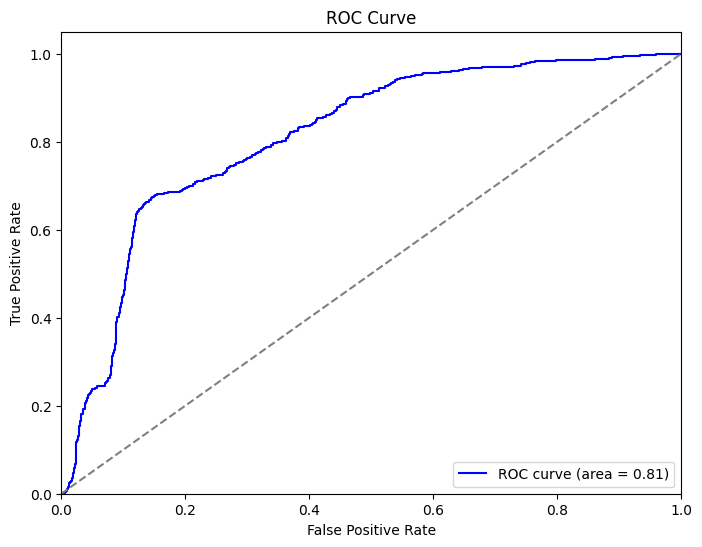

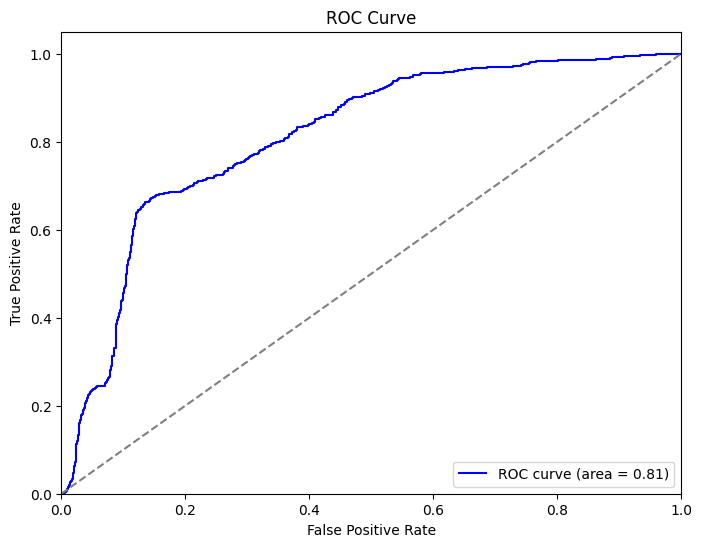

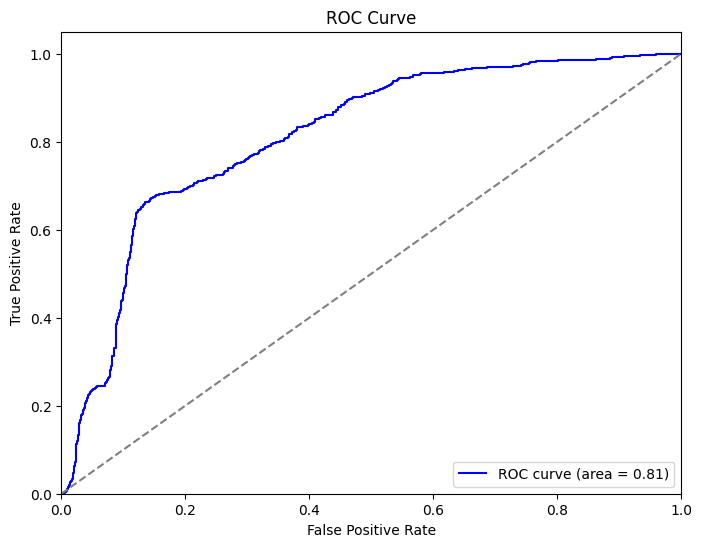

In [27]:
# Plot ROC curve for all models
plot_roc_curve(y_test, y_pred_proba_l1)
plot_roc_curve(y_test, y_pred_proba_l2)
plot_roc_curve(y_test, y_pred_proba_none)

## Comments:
---
The ROC curve allows us to evaluate the model's ability to distinguish between employees who stay and those who leave.

We dont observe big differences between the models.

---


# 8.Model Usage Method

The main objective of the model is to **maintain high sensitivity**, which implies using a **lower threshold (0.35)**. This approach helps capture a higher number of employees at risk, facilitating a **proactive prevention** strategy.

## Rationale for Using a 0.35 Threshold

- **High Sensitivity**: With a lower threshold, the model can capture more employees who are likely to leave the company.
- **Proactive Prevention**: Early identification of more employees at risk allows HR to **intervene earlier**, offering personalized solutions to prevent attrition.




In [30]:
# Calculate high-risk employees for each model
count_high_risk_l2, percentage_high_risk_l2 = calculate_high_risk_employees(y_pred_proba_l2, threshold=0.35)

# Print Results
print(f"High-risk employees: {count_high_risk_l2}, {percentage_high_risk_l2:.2f}%")

High-risk employees: 760, 25.33%


In [33]:
# Assuming 'y_pred_proba_l2' is the probability predictions for the L2 penalty model
manual_threshold = 0.35

# Filter employees with a probability greater than or equal to 0.35
high_risk_probs = y_pred_proba_l2[y_pred_proba_l2 >= manual_threshold]

# Sort employees with a probability greater than or equal to 0.35
high_risk_probs_sorted = np.sort(high_risk_probs)[::-1]

# Total number of high-risk employees
num_high_risk = len(high_risk_probs_sorted)

# Define percentiles
percentiles = [0.05, 0.2, 0.50]

# Dictionary to store percentile cutoffs and corresponding actions
actions = {}

for p in percentiles:
    # Find the cut-off index for the current percentile
    cut_index = int(p * num_high_risk)

    # Ensure there are enough employees to avoid index errors
    if cut_index > 0:
        # Determine the probability value at the cut-off point
        cutoff_value = high_risk_probs_sorted[cut_index - 1]

        # Store the cut-off probability value
        actions[p] = {"cutoff_value": cutoff_value, "num_employees": cut_index}

# Print the results for each percentile
for p, values in actions.items():
    print(f"Top {int(p * 100)}% of high-risk employees:")
    print(f"  - Probability cut-off: {values['cutoff_value']:.2f}")
    print(f"  - Number of employees: {values['num_employees']}")


Top 5% of high-risk employees:
  - Probability cut-off: 0.75
  - Number of employees: 38
Top 20% of high-risk employees:
  - Probability cut-off: 0.67
  - Number of employees: 152
Top 50% of high-risk employees:
  - Probability cut-off: 0.46
  - Number of employees: 380


## Actions to Be Taken for Employee Retention

### 1. **Top 5% - Intensive Actions** (High Risk)
These employees represent the group with the highest likelihood of leaving the company. Personalized and swift actions are required.

#### Recommended Actions:
- **Individual Retention Interviews**: Conduct one-on-one meetings to understand **concerns and expectations** regarding satisfaction, salary, and growth opportunities.
  
- **Personalized Career Plans**: Present specific career plans, highlighting **promotions** and **new challenges** within the company.

- **Salary Adjustments and Benefits**: Offer **salary adjustments** or improvements in benefits to retain these talents.

- **Mentoring with Leaders**: Provide **direct mentoring** with executives or senior leaders, showing appreciation and recognition. Hiring Master **Kapp** as a mentor would be a great choice.

---

### 2. **Top 20% - Moderate Actions** (Moderate Risk)
This group still faces a significant risk of leaving, but actions can be less personalized, focusing on **structural improvements**.

#### Recommended Actions:
- **Frequent Feedback and Follow-up**: Conduct **regular feedback sessions** to understand their needs and growth opportunities.

- **Mid-term Salary and Benefits Reviews**: Assess compensation packages and offer **performance-based bonuses** or benefit improvements.

- **Internal Promotions and New Opportunities**: Create opportunities for **internal mobility** or **role changes** within the company.

---

### 3. **Basic Actions for the Remaining Group** (Low Risk, but Important to Monitor)
This group has a relatively low risk of leaving but should still be monitored.

#### Recommended Actions:
- **Group Engagement**: Conduct **organizational climate surveys** and group meetings to understand general perceptions and improve well-being.

- **Regular Recognition**: Implement **recognition programs** such as quarterly or annual performance awards.

- **Improve Communication and Organizational Culture**: Promote **transparency** and encourage **Q&A sessions** with leadership.

- **Increase Growth Opportunities**: Develop **long-term development plans** and offer **continuous training**.

---

### Summary of Actions by Percentile:

| Percentile (Risk) | Actions |
|-------------------|---------|
| **Top 5%** (High Risk) | One-on-one Meetings, Personalized Career Plans, Salary Adjustments, Mentoring with Leaders |
| **Top 20%** (Moderate Risk) | Frequent Feedback, Internal Promotions, Mid-term Salary Reviews |
| **Preventive Action Group** (Low Risk) | Group Engagement, Recognition Programs, Improve Communication, Growth Opportunities |


# 9.SHAP VALUE
---
Finally, we use SHAP values to interpret the model and understand which features contribute most to the predictions.

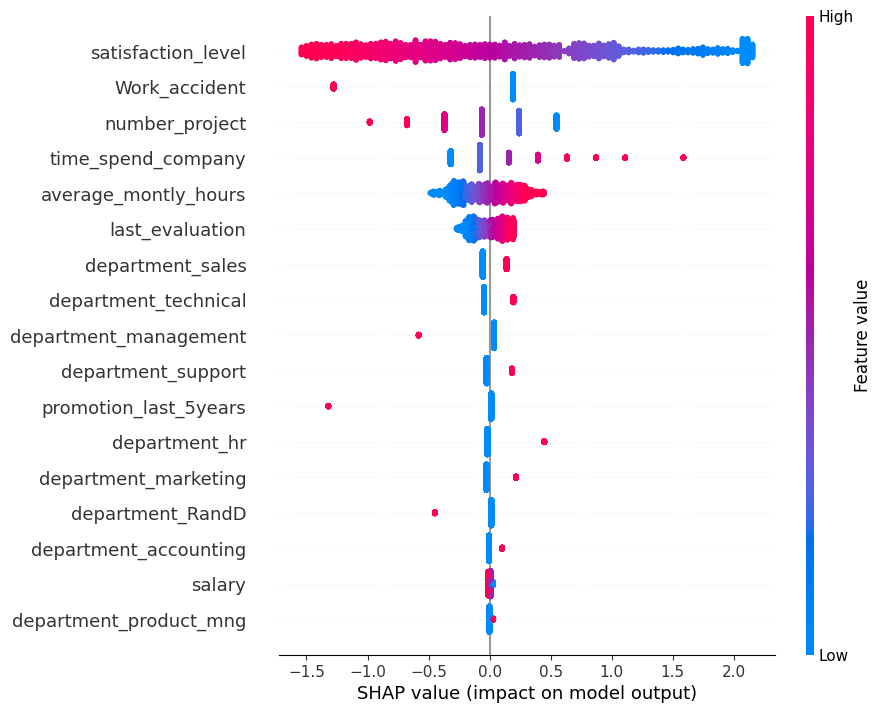

In [34]:
# Perform SHAP analysis for the L2 penalty model
perform_shap_analysis(model_l2, X_train_scaled, X_test_scaled, X_train.columns)

## Comments:
---

SHAP values allow us to understand how each feature impacts the model’s predictions at the individual level.

For example, a lower satisfaction level significantly increases the probability of attrition.

This interpretation provides actionable insights for HR teams to address the key factors influencing employee decisions to leave.

---

## Comparison of SHAP Results with the Initial Exploratory Analysis

---

### Summary of the Comparison

| Variable                        | Initial Exploratory Analysis                | SHAP Value Impact                                   | Conclusion                                       |
|----------------------------------|--------------------------------------------|-----------------------------------------------------|--------------------------------------------------|
| **Satisfaction Level**           | High Importance                            | High Importance, largest impact                     | Consistent with the initial analysis              |
| **Number of Projects**           | High Importance                            | Lower Importance                                    | Less important than expected                     |
| **Salary**                       | High Importance                            | Low Importance                                      | Less important than expected                     |
| **Promotion Last 5 Years**       | High Importance                            | Low Importance                                      | Less important than expected                     |
| **Work Accident**                | Low Importance                             | High Importance                                     | Much more important than initially predicted      |
| **Department**                   | Low Importance                             | Low Importance                                      | Aligned with the initial analysis                 |

---

### General Conclusion:

The SHAP values provide additional insights that complement and, in some cases, **contradict** the initial exploratory analysis. Variables like **work_accident**, which were not initially considered relevant, showed a much greater impact than expected. On the other hand, variables like **promotion_last_5years** and **salary**, which appeared important initially, turned out to have a lower impact on the model.

The SHAP value graph doesn’t tell us which variables are necessarily the most or least important in an absolute sense but instead shows **which features are contributing most to the model’s predictions**. For example, **satisfaction_level** has a consistent and high contribution across the predictions, while **work_accident** also shows strong influence, even though it was initially considered less significant.


## 10. Correlation matrix
---


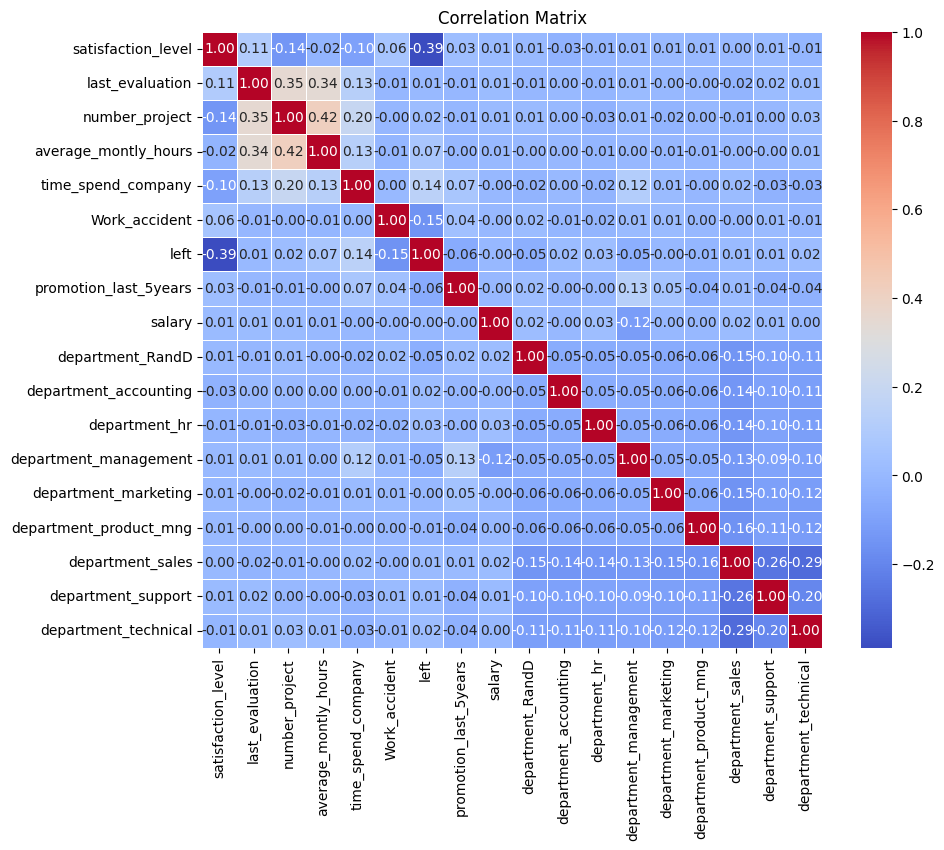

In [36]:
import seaborn as sns

# Optional Step 4: Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Comments:
---

The correlation matrix reveals that **satisfaction level** is the most significant factor correlated with employee attrition, followed by **work accidents** and **average monthly hours**. Interestingly, variables like **salary** and **promotion in the last 5 years**, which might have been expected to play a larger role, have minimal correlation with the likelihood of employees leaving. This suggests that **job satisfaction** and **work environment** factors might be more important than compensation or promotion in retaining employees.
